In [ ]:
# prompt: mount my google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
AGES = {1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"}
OCCUPATIONS = {0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
               4: "college/grad student", 5: "customer service", 6: "doctor/health care",
               7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
               12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
               17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer"}

In [ ]:
ratings = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ml-1m/ratings.dat",
                      sep='::',
                      engine='python',
                      encoding='latin-1',
                      names=['userid', 'movieid', 'rating', 'timestamp'])

max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1
print(len(ratings), 'ratings loaded')

1000209 ratings loaded


In [ ]:
ratings.head()

,userid,movieid,rating,timestamp,user_emb_id,movie_emb_id
0,1,1193,5,978300760,0,1192
1,1,661,3,978302109,0,660
2,1,914,3,978301968,0,913
3,1,3408,4,978300275,0,3407
4,1,2355,5,978824291,0,2354


In [ ]:
users = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ml-1m/users.dat",
                    sep='::',
                    engine='python',
                    encoding='latin-1',
                    names=['userid', 'gender', 'age', 'occupation', 'zipcode'])

users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])
print(len(users), 'descriptions of', max_userid, 'users loaded.')
users['user_emb_id'] = users['userid'] - 1

6040 descriptions of 6040 users loaded.


In [ ]:
users.head()

,userid,gender,age,occupation,zipcode,age_desc,occ_desc,user_emb_id
0,1,F,1,10,48067,Under 18,K-12 student,0
1,2,M,56,16,70072,56+,self-employed,1
2,3,M,25,15,55117,25-34,scientist,2
3,4,M,45,7,02460,45-49,executive/managerial,3
4,5,M,25,20,55455,25-34,writer,4


In [ ]:
movies = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ml-1m/movies.dat",
                     sep='::',
                     engine='python',
                     encoding='latin-1',
                     names=['movieid', 'title', 'genre'])
print(len(movies), 'descriptions of', max_movieid, 'movies loaded.')

movies['movie_emb_id'] = movies['movieid'] - 1

3883 descriptions of 3952 movies loaded.


In [ ]:
movies.head()

,movieid,title,genre,movie_emb_id
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [ ]:

print(len(ratings['userid'].drop_duplicates()), 'of the', max_userid, 'users rate at least one movie.')
print(len(ratings['movieid'].drop_duplicates()), 'of the', max_movieid, 'movies are rated.')


6040 of the 6040 users rate at least one movie.
3706 of the 3952 movies are rated.


In [ ]:




def preprocess_data(rating_df, num_users, num_items, init_value=0, average=False):
    """
    Function to pre-process the ratings data
    :param rating_df: ratings dataframe
    :param num_users: number of users
    :param num_items: number of items
    :param init_value:
    :param average:
    :return: 2D numpy array (processed ratings)
    """
    if average:
        matrix = np.full((num_users, num_items), 0.0)
        for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
            matrix[userID, itemID] = rating
        average_value = np.true_divide(matrix.sum(1), np.maximum((matrix != 0).sum(1), 1))
        indices = np.where(matrix == 0)
        matrix[indices] = np.take(average_value, indices[0])

    else:
        matrix = np.full((num_users, num_items), init_value)
        for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
            matrix[userID, itemID] = rating

    return matrix

In [ ]:
# Import packages
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers


def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode,
                  regularizer_decode, side_infor_size=0):
    """
    Function to build the deep autoencoders for collaborative filtering
    :param X: the given user-item interaction matrix
    :param layers: list of layers (each element is the number of neurons per layer)
    :param activation: choice of activation function for all dense layer except the last
    :param last_activation: choice of activation function for the last dense layer
    :param dropout: dropout rate
    :param regularizer_encode: regularizer for the encoder
    :param regularizer_decode: regularizer for the decoder
    :param side_infor_size: size of the one-hot encoding vector for side information
    :return: Keras model
    """

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')

    # Encoder Phase
    k = int(len(layers) / 2)
    i = 0
    for l in layers[:k]:
        x = Dense(l, activation=activation,
                  name='EncLayer{}'.format(i),
                  kernel_regularizer=regularizers.l2(regularizer_encode))(x)
        i = i + 1

    # Latent Space
    x = Dense(layers[k], activation=activation,
              name='LatentSpace',
              kernel_regularizer=regularizers.l2(regularizer_encode))(x)

    # Dropout
    x = Dropout(rate=dropout)(x)

    # Decoder Phase
    for l in layers[k + 1:]:
        i = i - 1
        x = Dense(l, activation=activation,
                  name='DecLayer{}'.format(i),
                  kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # Output
    output_layer = Dense(X.shape[1] - side_infor_size, activation=last_activation, name='UserScorePred',
                         kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # This model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
df = ratings.drop(columns =['userid','movieid'])
new_order = [ "user_emb_id", "movie_emb_id", "rating", "timestamp"]
df = df[new_order]
df


,user_emb_id,movie_emb_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291
...,...,...,...,...
1000204,6039,1090,1,956716541
1000205,6039,1093,5,956704887
1000206,6039,561,5,956704746
1000207,6039,1095,4,956715648


In [ ]:
num_users = df['user_emb_id'].unique().max() + 1
num_movies = df['movie_emb_id'].unique().max() + 1
train_df, test_df = train_test_split(df, stratify=df['user_emb_id'],
                                     test_size=0.1, random_state=1994)
train_df, validate_df = train_test_split(train_df, stratify=train_df['user_emb_id'],
                                         test_size=0.1, random_state=1994)

# Create sparse pivot tables with users in rows and items in columns
users_items_matrix_train_zero = preprocess_data(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = preprocess_data(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = preprocess_data(train_df, num_users, num_movies, 2)
users_items_matrix_train_three = preprocess_data(train_df, num_users, num_movies, 3)
users_items_matrix_train_four = preprocess_data(train_df, num_users, num_movies, 4)
users_items_matrix_train_five = preprocess_data(train_df, num_users, num_movies, 5)
users_items_matrix_train_average = preprocess_data(train_df, num_users, num_movies, average=True)
users_items_matrix_validate = preprocess_data(validate_df, num_users, num_movies, 0)
users_items_matrix_test = preprocess_data(test_df, num_users, num_movies, 0)

# Convert data types from int64 to float32 to use as tensor inputs for Keras model
users_items_matrix_train_zero = tf.convert_to_tensor(users_items_matrix_train_zero, dtype=tf.float32)
users_items_matrix_train_one = tf.convert_to_tensor(users_items_matrix_train_one, dtype=tf.float32)
users_items_matrix_train_two = tf.convert_to_tensor(users_items_matrix_train_two, dtype=tf.float32)
users_items_matrix_train_three = tf.convert_to_tensor(users_items_matrix_train_three, dtype=tf.float32)
users_items_matrix_train_four = tf.convert_to_tensor(users_items_matrix_train_four, dtype=tf.float32)
users_items_matrix_train_five = tf.convert_to_tensor(users_items_matrix_train_five, dtype=tf.float32)
users_items_matrix_train_average = tf.convert_to_tensor(users_items_matrix_train_average, dtype=tf.float32)
users_items_matrix_validate = tf.convert_to_tensor(users_items_matrix_validate, dtype=tf.float32)
users_items_matrix_test = tf.convert_to_tensor(users_items_matrix_test, dtype=tf.float32)


In [ ]:
# Model hyper-parameters
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras import backend as K

def masked_rmse(y_true, y_pred):
    """
    Function to define the masked root mean squared error
    :param y_true: true label
    :param y_pred: predicted label
    :return: masked root mean squared error
    """
    # Masked function
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    # Masked squared error
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    masked_rmse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
    return masked_rmse


def masked_rmse_clip(y_true, y_pred):
    """
    Function to define the masked root mean squared error with clipping
    :param y_true: true label
    :param y_pred: predicted label
    :return: masked root mean squared error with clipping
    """
    # Masked function
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    y_pred = K.clip(y_pred, 1, 5)
    # Masked squared error
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    masked_rmse_clip = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
    return masked_rmse_clip


layers = [512, 512, 1024, 512, 512]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

# Build model
Deep_AE = Deep_AE_model(users_items_matrix_train_zero,
                        layers, activation, last_activation, dropout,
                        regularizer_encode, regularizer_decode)

# Compile model
Deep_AE.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss=masked_rmse, metrics=[masked_rmse_clip])

# Print model summary to preserve automatically in CometML dashboard
print(Deep_AE.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 512)               2023936   
                                                                 
 EncLayer1 (Dense)           (None, 512)               262656    
                                                                 
 LatentSpace (Dense)         (None, 1024)              525312    
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 DecLayer1 (Dense)           (None, 512)               524800    
                                                                 
 DecLayer0 (Dense)           (None, 512)               2626

In [ ]:

def show_error(history, skip):
    """
    Function to show model loss
    :param history: model log history
    :param skip: interval to be skipped
    :return: visualization of model loss
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # Matplotlib settings
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


def show_rmse(history, skip):
    """
    Function to show the RMSE evaluation metric
    :param history: model log history
    :param skip: interval to be skipped
    :return: visualization of model RMSE
    """
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    # Matplotlib settings
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


Epoch 1/500
12/12 - 10s - loss: 8.1482 - masked_rmse_clip: 2.8699 - val_loss: 8.0944 - val_masked_rmse_clip: 2.8708 - 10s/epoch - 795ms/step
Epoch 2/500
12/12 - 6s - loss: 8.1354 - masked_rmse_clip: 2.8693 - val_loss: 8.0782 - val_masked_rmse_clip: 2.8705 - 6s/epoch - 468ms/step
Epoch 3/500
12/12 - 8s - loss: 8.1173 - masked_rmse_clip: 2.8667 - val_loss: 8.0594 - val_masked_rmse_clip: 2.8701 - 8s/epoch - 644ms/step
Epoch 4/500
12/12 - 6s - loss: 8.0972 - masked_rmse_clip: 2.8649 - val_loss: 8.0388 - val_masked_rmse_clip: 2.8695 - 6s/epoch - 532ms/step
Epoch 5/500
12/12 - 8s - loss: 8.0761 - masked_rmse_clip: 2.8626 - val_loss: 8.0159 - val_masked_rmse_clip: 2.8684 - 8s/epoch - 671ms/step
Epoch 6/500
12/12 - 6s - loss: 8.0520 - masked_rmse_clip: 2.8584 - val_loss: 7.9894 - val_masked_rmse_clip: 2.8668 - 6s/epoch - 530ms/step
Epoch 7/500
12/12 - 8s - loss: 8.0250 - masked_rmse_clip: 2.8532 - val_loss: 7.9583 - val_masked_rmse_clip: 2.8640 - 8s/epoch - 645ms/step
Epoch 8/500
12/12 - 8s - 

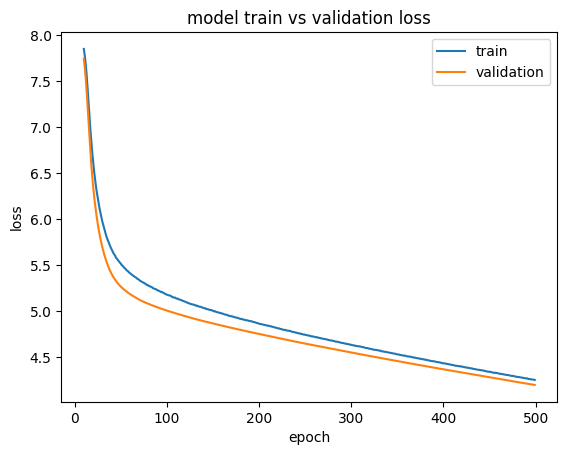

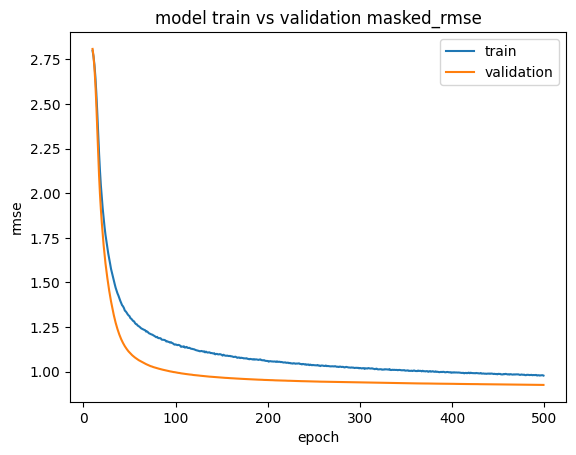

In [28]:

hist_Deep_AE = Deep_AE.fit(
    x=users_items_matrix_train_zero, y=users_items_matrix_train_zero, epochs=500, batch_size=512,
    validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=2, mode='auto')]
)

# Show model loss
show_error(hist_Deep_AE, 10)
# Show RMSE metric
show_rmse(hist_Deep_AE, 10)


In [29]:
loss, test_result_deep = Deep_AE.evaluate(users_items_matrix_train_zero, users_items_matrix_test)
metrics = {
    'masked_rmse_loss': loss,
    'masked_rmse_test': test_result_deep
}

189/189 [==============================] - 5s 25ms/step - loss: 4.2067 - masked_rmse_clip: 0.9302
